# **Import library**

In [ ]:
!pip install livelossplot

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk

In [4]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical , plot_model
from sklearn.model_selection import train_test_split

# **Importing data set**

In [5]:
data= pd.read_csv("ner_dataset.csv",encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


# **Processing data**

In order for the model to learn, we cant just simply  give it a  list of words and tags  then hope it going to learn it just like a human being.
Different from human, the machine can only learn  from numbers. Therefore, the 1st step is to give each words  and tags their own identify numers (aka ID)

In [6]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
tags = list(set(data['Tag'].values))
#  Creating word -> ID dictionary
token_idx =  {tok:idx+1 for  idx, tok in enumerate(words)}
# Creating tag -> ID dictionary
tag_idx =  {tok:idx for  idx, tok in enumerate(tags)}

#  reverse dictionary for reverse call ( for debugging or other purposes)
idx_token =  {idx+1:tok  for  idx, tok in enumerate(words)}
idx_tag =  {idx:tok for  idx, tok in enumerate(tags)}


-------------------------------------------------------

**More Information about the Data set**

In [10]:
print('total words of the whole data set :',len(data['Word'].values))
print('number of  words in the data set:',len(token_idx))
print('number of  tags in the data set:',len(tag_idx))
print( 'all the tag available : ', tags)
print( 'tags and its ID : \n', tag_idx)

total words of the whole data set : 1048575
number of  words in the data set: 35178
number of  tags in the data set: 17
all the tag available :  ['I-gpe', 'I-art', 'B-eve', 'I-org', 'B-art', 'B-tim', 'I-per', 'B-geo', 'B-per', 'I-eve', 'O', 'I-nat', 'I-tim', 'B-gpe', 'I-geo', 'B-nat', 'B-org']
tags and its ID : 
 {'I-gpe': 0, 'I-art': 1, 'B-eve': 2, 'I-org': 3, 'B-art': 4, 'B-tim': 5, 'I-per': 6, 'B-geo': 7, 'B-per': 8, 'I-eve': 9, 'O': 10, 'I-nat': 11, 'I-tim': 12, 'B-gpe': 13, 'I-geo': 14, 'B-nat': 15, 'B-org': 16}


------------------------------------------

 Now we align the ID for each word and tag into the data set

In [14]:
data['Word_idx'] = data['Word'].map(token_idx)
data['Tag_idx'] = data['Tag'].map(tag_idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,20238,10
1,NaN,of,IN,O,31906,10
2,NaN,demonstrators,NNS,O,3988,10
3,NaN,have,VBP,O,7667,10
4,NaN,marched,VBN,O,8135,10


 the next step is to group all the words and tags of them in to their own sentence . we will do this by filling up all the "NAN"  using its sentence ID  , and using "groupby" to group them up

In [15]:
datafill = data.fillna(method='ffill', axis=0)
data_group = datafill.groupby(['Sentence #'],as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
data_group.head()


<ipython-input-15-b491dcdbd70d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datafill = data.fillna(method='ffill', axis=0)


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[20238, 31906, 3988, 7667, 8135, 28575, 3449, ...","[10, 10, 10, 10, 10, 10, 7, 10, 10, 10, 10, 10..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[27140, 1529, 5283, 6856, 33272, 1905, 18792, ...","[13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[29373, 25791, 9044, 28342, 10708, 14751, 3248...","[10, 10, 5, 10, 10, 10, 10, 10, 7, 10, 10, 10,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[22353, 32447, 4624, 16886, 4694, 20630, 12408...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[32703, 13786, 6584, 15416, 30092, 10967, 3404...","[7, 10, 10, 8, 6, 10, 5, 10, 7, 10, 13, 10, 13..."


---------------------------------------------------

Since the lenght of the Input to the model need to be same and all the sentence is not alway have the same lenght , there for padding is nessesary for the finnal training set    

In [16]:
# get len of token and tags
n_token = len(words)
n_tags = len(tags)

In [17]:
#Pad tokens (X var)---------------------------
token_idx_set = data_group['Word_idx'].tolist()
max_len = max([len(t) for t in token_idx_set])
X = pad_sequences(token_idx_set, maxlen=max_len, dtype='int32', padding='post', value= n_token-1 )
# well padding  all the emty values  behind with the ID of the last word in the data set
# please note that this word should  have the "O" tag (empty tag)  so that it doesnt affect the finnal result of the trainning

#Pad tokens (Y var)---------------------------
tag_idx_set = data_group['Tag_idx'].tolist()
Y = pad_sequences(tag_idx_set, maxlen=max_len, dtype='int32', padding='post', value= tag_idx["O"])
# We ll do the same  down here with the Tags  with we ll fill it with  the "O" tags instead
print('X [0]= ',X[0])
print('Y [0]= ',Y[0])

X [0]=  [20238 31906  3988  7667  8135 28575  3449  1905 34770 25698 18852 32487
  5253 34707 23826 25698 18480 31906 28035 34697 34865 15558  9095 28297
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177]
Y [0]=  [10 10 10 10 10 10  7 10 10 10 10 10  7 10 10 10 10 10 13 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10]


Since we are using  keras LSTM model  for classification problem  therefore  we need to transform the class into binary format ( in this case well be tranforming the tags ID) in order for the trainning step to work proberly

In [18]:
Y = [to_categorical(i, num_classes=len(tag_idx)) for i in Y]

In [21]:
print('Y [0][0]= ',Y[0][0],'=' ,tag_idx['O'], '= tag O ')

Y [0][0]=  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] = 10 = tag O 


For the finnal step , we going to seperate the above data into random rainning set and testing set   

In [20]:
# splitting test data and testing data
tok_, test_tokens, tag_, test_tags = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=2000)
train_tokens, value_tokens, train_tags, value_tags = train_test_split(tok_,tag_,test_size = 0.25,train_size =0.75, random_state=2000)


In [34]:
print('trainning data \n words :',train_tokens.shape,'\n tags:',np.array(train_tags).shape)

trainning data 
 words : (32372, 104) 
 tags: (32372, 104, 17)


# **Building LSTM model**

  first we creating random seed for  the trainning and testing and embeding dimention

In [35]:
np.random.seed(34)
tf.random.set_seed(3)
in_dim = len(list(set(data['Word'].to_list())))+1
out_dim = 64

Next step is to create  the LSTM model  with 4 layers

In [80]:

model = Sequential()
#Embedding layer
model.add(Embedding(input_dim=in_dim, output_dim=out_dim, input_length=max_len))
#bi-LSTM layer
model.add(Bidirectional(LSTM(units=out_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
#LSTM layer
model.add(LSTM(units=out_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
#timeDistributed Layer
model.add(TimeDistributed(Dense(n_tags, activation='sigmoid')))

# Compile model
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None,max_len))
plot_model(model)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 104, 64)             │       2,251,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 104, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 104, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 104, 17)             │           1,105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,368,017 (9.03 MB)

 Trainable params: 2,368,017 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

# **Trainning**

In [111]:
epochs=10
batch=100
tra_acc=[]
tra_loss=[]
val_acc=[]
val_loss=[]
for i in range(epochs):
  hist = model.fit(train_tokens,np.array(train_tags), batch_size=batch, verbose=1, epochs=1, validation_split=0.2)
  tra_acc.append(hist.history['accuracy'])
  tra_loss.append(hist.history['loss'])
  val_acc.append(hist.history['val_accuracy'])
  val_loss.append(hist.history['val_loss'])

259/259 ━━━━━━━━━━━━━━━━━━━━ 196s 753ms/step - accuracy: 0.9764 - loss: 0.0728 - val_accuracy: 0.9773 - val_loss: 0.0665
259/259 ━━━━━━━━━━━━━━━━━━━━ 187s 721ms/step - accuracy: 0.9783 - loss: 0.0630 - val_accuracy: 0.9806 - val_loss: 0.0594
259/259 ━━━━━━━━━━━━━━━━━━━━ 189s 729ms/step - accuracy: 0.9829 - loss: 0.0547 - val_accuracy: 0.9857 - val_loss: 0.0493
259/259 ━━━━━━━━━━━━━━━━━━━━ 190s 733ms/step - accuracy: 0.9871 - loss: 0.0448 - val_accuracy: 0.9883 - val_loss: 0.0428
259/259 ━━━━━━━━━━━━━━━━━━━━ 186s 720ms/step - accuracy: 0.9897 - loss: 0.0378 - val_accuracy: 0.9906 - val_loss: 0.0379
259/259 ━━━━━━━━━━━━━━━━━━━━ 187s 722ms/step - accuracy: 0.9921 - loss: 0.0317 - val_accuracy: 0.9913 - val_loss: 0.0348
259/259 ━━━━━━━━━━━━━━━━━━━━ 183s 707ms/step - accuracy: 0.9931 - loss: 0.0273 - val_accuracy: 0.9916 - val_loss: 0.0328
259/259 ━━━━━━━━━━━━━━━━━━━━ 186s 717ms/step - accuracy: 0.9939 - loss: 0.0240 - val_accuracy: 0.9917 - val_loss: 0.0318
259/259 ━━━━━━━━━━━━━━━━━━━━ 186

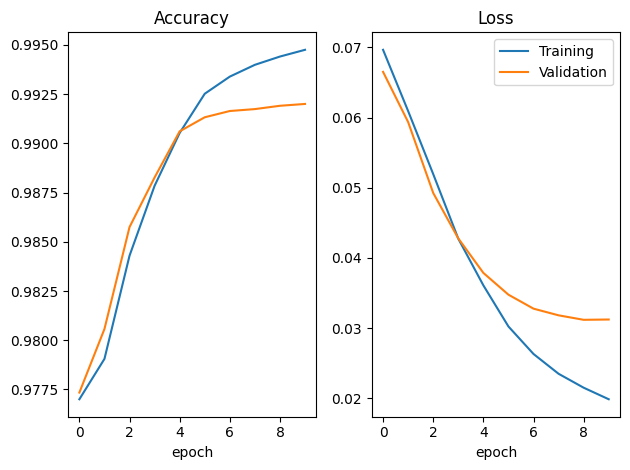

In [112]:
plt.subplot(1, 2, 1)
plt.plot(range(epochs), tra_acc, label = "Training")
plt.plot(range(epochs), val_acc, label = "Validation")
plt.xlabel('epoch')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), tra_loss, label = "Training")
plt.plot(range(epochs), val_loss, label = "Validation")
plt.xlabel('epoch')
plt.title('Loss')
plt.legend()

plt.tight_layout()

plt.show()

# **Testing and evaluate**

In [113]:
model.evaluate(test_tokens, np.array(test_tags))

150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9922 - loss: 0.0310


[0.03092070482671261, 0.9921609163284302]

In [114]:
input_test = np.random.randint(0, len(test_tokens))
#input_test=3
test = test_tokens[input_test]
p = model.predict(np.array([test]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(test_tags), axis=-1)[input_test]
print("{:15}{:5}\t {}\n".format("Word","True","Prediction"))
print("-"*30)
temp=test[2]
for w,true,pred in zip(test, y_true, p[0]):
  if w != temp:
    print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))
    temp = w

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Word           True 	 Prediction

------------------------------
GDP            O    	O
fell           O    	O
nearly         O    	O
5              O    	O
%              O    	O
in             O    	O
2009           B-tim	B-tim
before         I-tim	O
gaining        O    	O
back           O    	O
4              O    	O
%              O    	O
in             O    	O
2010           B-tim	B-tim
,              O    	O
and            O    	O
unemployment   O    	O
rose           O    	O
above          O    	O
12             O    	O
%              O    	O
in             O    	O
2010           B-tim	B-tim
,              O    	O
as             O    	O
the            O    	O
global         O    	O
recession      O    	O
impacted       O    	O
many           O    	O
segments       O    	O
of             O    	O
the            O    	O
economy        O    	O
.              O    	O
Salif          O    	O
